# Heart Disease Risk Assessment using Bayesian Networks

### Authors: Matteo Fasulo, Luca Tedeschini, Antonio Gravina, Luca babboni

### Course: Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna

### Overview

**Cardiovascular diseases** (CVDs) are the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 32% of all deaths worldwide. Four out of 5 CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [[1]](#1). 

The main risk factors for **heart disease** are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects may include raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity [[1]](#1). Since the 1930s, research has identified diverse **CVD risk factors** [[2]](#2). Notably, the World Health Organization categorizes factors as modifiable (influenced by lifestyle) and non-modifiable [[3]](#3). Interestingly, modifiable factors can be significantly impacted by individual choices and interventions. 

In this notebook, we will use a **Bayesian Network** to assess the **risk of heart disease** in a patient based on these risk factors. We will face the modelling of **causal relations** between the risk factors and the disease, and we will use the network to make **predictions** about the risk of heart disease in a patient. The aim is to learn a model which **given** the risk factors of a patient as input (**evidence**), can predict the probability of the patient having heart disease. The causal relations between the risk factors and the disease will be both learned from data and from **domain knowledge** found in the **literature** and in **medical guidelines**.

The work was inspired by a paper [[4]](#4) in which the authors used a Bayesian Network to assess the risk of heart disease in a patient. Their work guided us in the choice of the risk factors and in the structure of the network. However, we will use a different dataset and we will use a different approach to learn the parameters of the network.

# Libraries

In [6]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# Preprocessing

The original dataset 

In [7]:
df = pd.read_csv(f'data{os.sep}heart.csv')

df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

df['ExerciseAngina'] = df['ExerciseAngina'].apply(
    lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(
    lambda x: False if x == 0 else True)

df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)
df["Age"] = pd.qcut(x=df["Age"], q=2, labels=["young", "old"])
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, 1000], labels=[
                         "normal", "high", "very high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[
                           0, 200, 240, 1000], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.cut(x=df["MaxHR"], bins=3)
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=3, labels=[
                       "low", "medium", "high"])

In [8]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## Test with changing score of Hill climbing plus Kfold

In [9]:
from sklearn.model_selection import KFold
kfold = KFold(10, shuffle=True, random_state=12)

def bayesian_kfold(kfold, model):
    score = []
    for train, test in kfold.split(df):
        model.fit(df.iloc[train, :], estimator=BayesianEstimator, prior_type="BDeu")
        y_pred = model.predict(df.iloc[test, :-1])
        score.append(fbeta_score(df.iloc[test, -1], y_pred[target_variable], beta=2))
    return sum(score) / len(score)

  0%|          | 0/1000000 [00:00<?, ?it/s]

Score: k2score


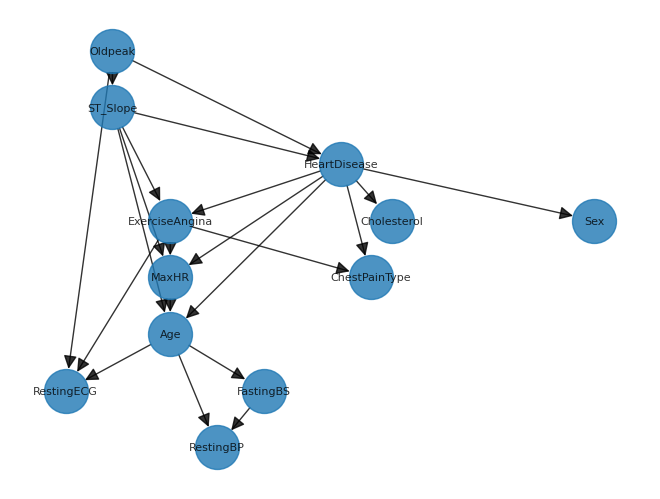

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Score: bdeuscore


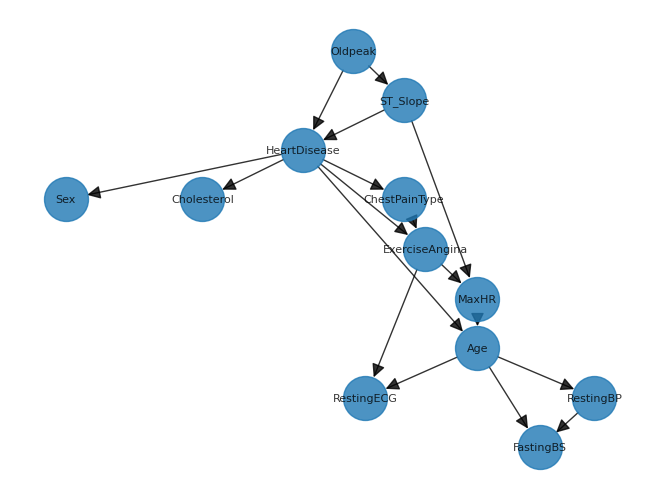

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Score: bdsscore


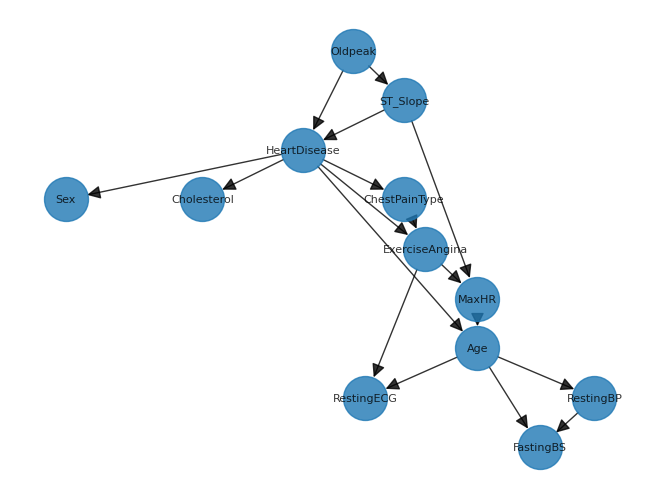

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Score: bicscore


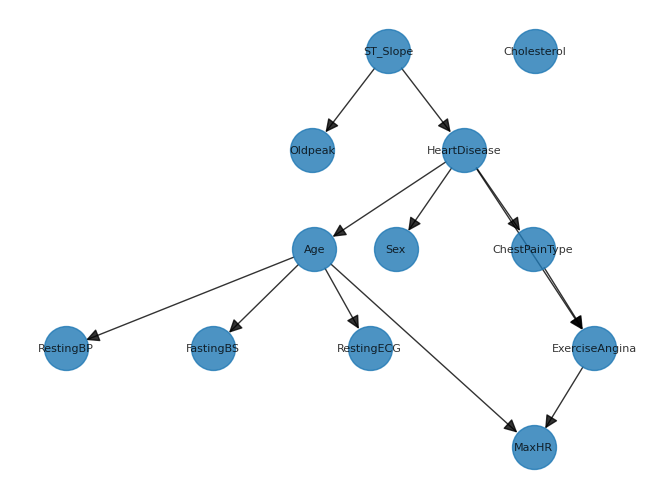

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Score: aicscore


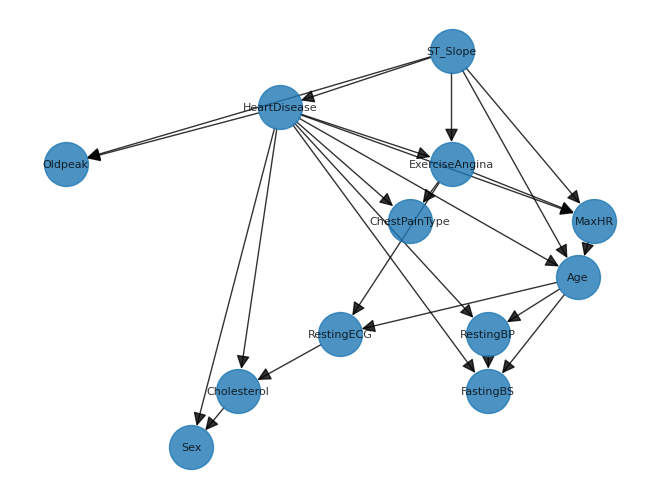

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [10]:
scores = {}
# Building different networks by using HillClimbing with different scoring methods
for scoring in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    network = HillClimbSearch(df, use_cache=False).estimate(scoring_method=scoring)
    pos = nx.nx_agraph.graphviz_layout(network, prog="dot")
    print(f"Score: {scoring}")
    nx.draw(network, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)
    plt.show()
    model = BayesianNetwork(network)
    scores[scoring] = bayesian_kfold(kfold, model)

In [11]:
pd.DataFrame(scores, index = [0])

,k2score,bdeuscore,bdsscore,bicscore,aicscore
0,0.860389,0.869535,0.869535,0.865523,0.855633


From the results below we noticed that they have an overall similar fbeta score. However, the networks are kinda different from each other and for each network there are some problems with the semantics. This means that:
- the choice of the scoring method does not influence so much the fbeta results, even if the structures of the networks are different
- since the semantic is problematic, we need to add some constraint through blacklist/whitelist, so we cannot fully automatize the construction of the network 

So we can take as scoring method 'bdeuscore' and build an unconstraied network which we can improve manually.

  0%|          | 0/1000000 [00:00<?, ?it/s]

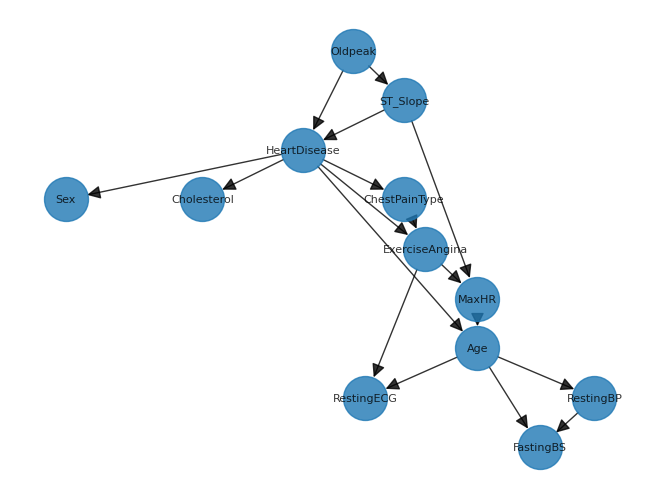

In [12]:
network = HillClimbSearch(df, use_cache=False).estimate(scoring_method='BDeuScore')
pos = nx.nx_agraph.graphviz_layout(network, prog="dot")
nx.draw(network, pos, with_labels=True, node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

Ok, good but we want to express some edges and remove other with no causal meaning. We proceed to remove:
- HeartDisease -> Cholesterol
- Oldpeak -> HeartDisease
- ST_Slope -> HeartDisease
- ST_Slope -> MaxHR
- Nothing affects Age
- Nothing affects Sex

In [13]:
black_list = [(target_variable, 'Cholesterol'),
              ('Oldpeak', target_variable),
              ('ST_Slope', target_variable),
              ('ST_Slope', 'MaxHR')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [14]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

  0%|          | 0/1000000 [00:00<?, ?it/s]

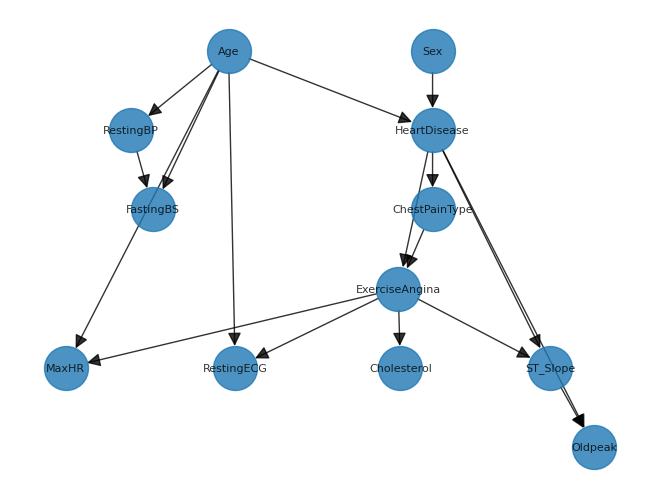

In [15]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

Now we add some significant edges.

In [16]:
estimated_model.remove_edge('ExerciseAngina', 'Cholesterol')
estimated_model.add_edge('Sex', 'Cholesterol')
estimated_model.add_edge('Cholesterol', target_variable)
estimated_model.add_edge('Age', 'Cholesterol')

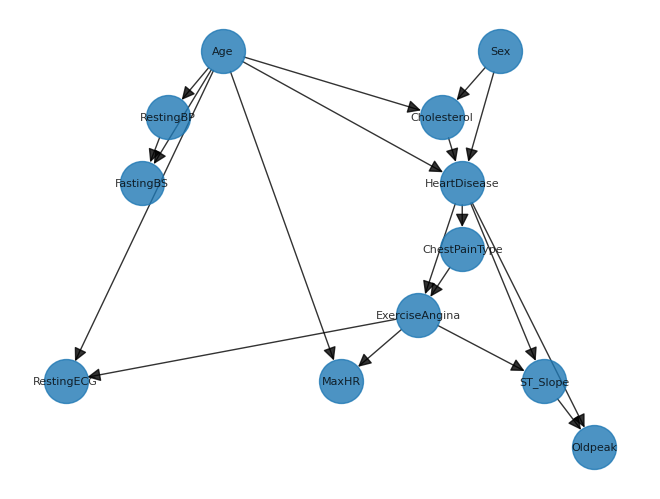

In [17]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

And now we print the fbeta score with cross validation technique.

In [18]:
model = BayesianNetwork(estimated_model)
fbeta = bayesian_kfold(kfold, model)
print(f'F-beta score: {fbeta}')

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

F-beta score: 0.8717007055816012


The F-beta score is slightly higher than the one without constraint, and the network is also semantically better than the unconstrained one.

### References

<a id="1">[1]</a>
World Health Organization. (2024). Cardiovascular diseases (CVDs). <https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)>

<a id="2">[2]</a>
Mahmood, S. S., Levy, D., Vasan, R. S., & Wang, T. J. (2014). The Framingham Heart Study and the epidemiology of cardiovascular disease: a historical perspective. Lancet (London, England), 383(9921), 999–1008. <https://doi.org/10.1016/S0140-6736(13)61752-3>

<a id="3">[3]</a>
WHO CVD Risk Chart Working Group (2019). World Health Organization cardiovascular disease risk charts: revised models to estimate risk in 21 global regions. The Lancet. Global health, 7(10), e1332–e1345. <https://doi.org/10.1016/S2214-109X(19)30318-3>

<a id="4">[4]</a>
Ordovas, J.; Rios-Insua, D.; Santos-Lozano, A.; Lucia, A.; Torres, A.; Kosgodagan, A.; and Camacho, J. (2023). A bayesian network model for predicting cardiovascular risk. Computer Methods and Programs in Biomedicine. <https://doi.org/10.1016/j.cmpb.2023.107405>